## com_corr_strat
Compute mean stratification from time-averaged temperature and salinity. Account for grid breathing based on mean SSH.

Potential improvments:
* operate on large x,y chunks, re-chunking on z. Custom distribute acts on x, y only. This would allow to parallelize truediv over z chunks. Suggestion for chunking: 600*600 (x,y), 150 (z)
* BUT: I don't know how to not compute land points. It iseasy to implement this by chunk (taking the max of tmaskutil in the dist_write. This is more efficient with smaller x,y chunks

This notebook is a dev notebook for processing eNATL60 data on occigen


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

from pathlib import Path
import os
import numpy as np

import xarray as xr
#from xgcm import Grid
#from xorca.lib import load_xorca_dataset
from itidenatl.eos import bvf2

In [2]:
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster(threads_per_worker=7) #n_workers=24, threads_per_worker=1, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

/scratch/cnt0024/ige2071/nlahaye/conda38/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41953 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:41891 Dashboard: http://127.0.0.1:41953/status,Cluster Workers: 8 Cores: 56 Memory: 251.63 GiB


In [3]:
scratch = Path(os.getenv("SCRATCHDIR"))
grid_path = scratch #Path("/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-I/")
mean_path = Path("/work/CT1/ige2071/SHARED/mean")

#ssh_fname = "global_mean_gridT-2D.zarr"
temp_fname = "global_mean_gridT.zarr"
salt_fname = "global_mean_gridS.zarr"
#grid_fname = "mesh_mask_eNATL60_3.6.nc"
zgrid_name = "eNATL60_mean_grid_z.zarr" 

out_file = scratch/"prov.zarr" #"global_mean_bvf.zarr"

#grid_files = [grid_path/grid_fname]

In [4]:
### load SSH, temperature and salinity: wrappers
dims = {"ssh": ("x_c", "y_c"), "temp":("x_c", "y_c", "z_c"), "salt":("x_c", "y_c", "z_c")}
dimap = {"x":"x_c", "y":"y_c", "deptht":"z_c"}
inmap = {val:key for key,val in dimap.items()}

def get_var_chkopen(path, varname, chks={}):
    da = xr.open_zarr(path, chunks=chks, overwrite_encoded_chunks=True)[varname].squeeze()
    da = da.rename({dim:dimap[dim] for dim in da.dims})
    #da = da.chunk({dim:chks[dim] for dim in da.dims})
    return da

### the one I should use is this one
def get_var_chkafter(path, varname, chks={}):
    da = xr.open_zarr(path)[varname].squeeze()
    da = da.chunk({dim:chks[dim] for dim in da.dims})
    da = da.rename({dim:dimap[dim] for dim in da.dims})
    return da

In [5]:
### load data and arrange coordinates
chunks = {"x_c":400, "y_c":400, "z_c":-1, "z_l":-1}

ds = xr.open_zarr(scratch/zgrid_name)
if chunks:
    ds = ds.chunk(chunks)
else:
    chunks = ds.chunks

to_coords = ["depth_c_3d", "depth_l_3d", "e3t", "e3w", "tmask"]
to_coords = [co for co in to_coords if co in ds.data_vars]
ds = ds.set_coords(to_coords)

ds

<xarray.Dataset>
Dimensions:     (x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates: (12/14)
    depth_c     (z_c) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    depth_c_3d  (z_c, y_c, x_c) float32 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    depth_l     (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    depth_l_3d  (z_l, y_c, x_c) float32 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    e3t         (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    e3w         (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    ...          ...
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(400, 400), meta=np.ndarray>
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c         (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    hbot        (y_c, x_c) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    sossheig    (y_c, x_c) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>

In [6]:
### load and merge temperature and salinity
get_var = get_var_chkafter
chks = {key:ds.chunks[val] for key,val in dimap.items()}
ds = ds.merge(get_var(mean_path/temp_fname, "votemper", chks), join="override") 
ds = ds.merge(get_var(mean_path/salt_fname, "vosaline", chks), join="override") 

print("dataset is {:.1f} GB".format(ds.nbytes/1e9))
ds

dataset is 486.9 GB


<xarray.Dataset>
Dimensions:     (x_c: 8354, y_c: 4729, z_c: 300, z_l: 300)
Coordinates: (12/14)
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c         (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
    depth_c     (z_c) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    depth_c_3d  (z_c, y_c, x_c) float32 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    depth_l     (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    ...          ...
    e3w         (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    llat_cc     (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    llon_cc     (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(400, 400), meta=np.ndarray>
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    hbot        (y_c, x_c) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    sossheig    (y_c, x_c) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    votemper    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    vosaline    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>

In [7]:
### Select fields that are needed for computation
vars_need = ["votemper", "vosaline"] # I should use depth_l_3d
coor_need = ["e3w", "depth_l_3d", "tmask", "tmaskutil", "llon_cc", "llat_cc", "depth_l"]
ds = ds.get(vars_need+coor_need)
keep_coords = vars_need+coor_need+[k for k in ds.dims.keys()]
ds = ds.reset_coords([co for co in ds.coords if co not in keep_coords], drop=True)
#ds = ds.set_coords([co for co in coor_need if co in ds.data_vars])
#ds = ds.rename({"depth_l_3d":"depth_l"})
ds

,Array,Chunk
Bytes,88.30 GiB,366.21 MiB
Shape,"(300, 4729, 8354)","(300, 400, 400)"
Count,3893 Tasks,252 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,44.15 GiB,183.11 MiB
Shape,"(300, 4729, 8354)","(300, 400, 400)"
Count,3893 Tasks,252 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [8]:
def get_bvf(ds, return_ds=False):
    bvf = bvf2(ds.where(ds.tmask), zcoord="depth_l_3d").chunk({"z_l":chunks["z_l"]}) #.astype(np.float32)
    bvf = bvf.reset_coords([co for co in bvf.coords if len(bvf[co].dims)>2], drop=True)
    if return_ds:
        put_coords = ["llon_cc", "llat_cc", "depth_l"]
        bvf = bvf.to_dataset().assign_coords({co:ds[co] for co in put_coords})
        for var in bvf.coords:
            bvf[var].encoding.pop("chunks",None) # otherwise writing zarr raise error
        put_attrs = {"grid_file":str(scratch/zgrid_name), "mean_temp":str(mean_path/temp_fname), 
                    "mean_salt":str(mean_path/salt_fname)}
        bvf.attrs = put_attrs
    return bvf

In [9]:
from itertools import product

def dist_write_chunks(ds, path):
    """ utilitary function that loops over chunks to store a DataArray in a zarr archive (append mode)"""
    #dim_chk = [next(di for di in da.dims if di.startswith(dim)) for dim in dims]
    if isinstance(ds, xr.DataArray):
        name = ds.name if ds.name else "data"
        ds = ds.to_dataset(name=name)
    dims = [*ds.chunks.keys()]
    chks = [np.r_[0, np.array(chk).cumsum()] for chk in ds.chunks.values()]
    nks = [len(chk) for chk in ds.chunks.values()]        
    print("total number of chunks:", np.product(nks), dims, nks)
    ext = [np.arange(nk) for nk in nks]
    for chs in product(*ext):
        isel = {dim:slice(*chks[ii][chs[ii]:chs[ii]+2]) for ii,dim in enumerate(dims)}
        print("now writing", isel)
        ds.isel(isel).to_zarr(path, mode="a", region=isel)


In [10]:
%%time
bvf = get_bvf(ds, return_ds=True) # .isel(x_c=slice(0, 1200), y_c=slice(0, 1200))
bvf.drop_vars("bvf").to_zarr(out_file, mode="w", compute=True, consolidated=True)
bvf.to_zarr(out_file, mode="a", compute=False)
bvf

CPU times: user 2.93 s, sys: 251 ms, total: 3.18 s
Wall time: 5.52 s


<xarray.Dataset>
Dimensions:    (x_c: 8354, y_c: 4729, z_l: 300)
Coordinates:
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(400, 400), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    depth_l    (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
Data variables:
    bvf        (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
Attributes:
    grid_file:  /scratch/cnt0024/ige2071/nlahaye/eNATL60_mean_grid_z.zarr
    mean_temp:  /work/CT1/ige2071/SHARED/mean/global_mean_gridT.zarr
    mean_salt:  /work/CT1/ige2071/SHARED/mean/global_mean_gridS.zarr

In [11]:
%%time 
### run computation and store
dist_write_chunks(bvf, path=out_file)

total number of chunks: 252 ['x_c', 'y_c', 'z_l'] [21, 12, 1]
now writing {'x_c': slice(0, 400, None), 'y_c': slice(0, 400, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(400, 800, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(800, 1200, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(1200, 1600, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(1600, 2000, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(2000, 2400, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(2400, 2800, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(2800, 3200, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(3200, 3600, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, No

In [12]:
ds_re = xr.open_zarr(out_file)
ds_re

<xarray.Dataset>
Dimensions:    (x_c: 8354, y_c: 4729, z_l: 300)
Coordinates:
    depth_l    (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(400, 400), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    bvf        (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
Attributes:
    grid_file:  /scratch/cnt0024/ige2071/nlahaye/eNATL60_mean_grid_z.zarr
    mean_salt:  /work/CT1/ige2071/SHARED/mean/global_mean_gridS.zarr
    mean_temp:  /work/CT1/ige2071/SHARED/mean/global_mean_gridT.zarr

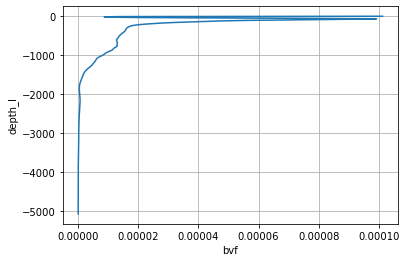

In [15]:
i_rng = slice(4014-1, 4134)
j_rng = slice(1438-1, 1576)

sds = ds_re.isel(x_c=i_rng, y_c=j_rng)
sds.bvf.mean(dim=("x_c", "y_c")).plot(y="depth_l")
plt.grid(True)

In [ ]:
bvf_moy = sds.bvf.mean(dim=("x_c", "y_c")).

## testings


fraction of land points: 0.50
would compute 157 over 220 (fraction not computed: 0.29)


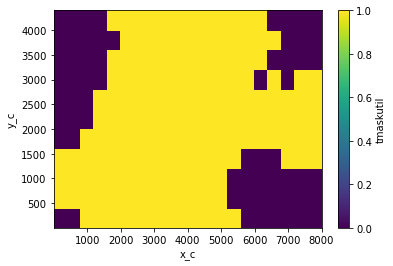

In [20]:
### look at impact of chunking on proportion of non-computed tiles
nchk = 400
print("fraction of land points: {:.2f}".format((ds.tmaskutil==0).mean().values))
comp_tile = ds.tmaskutil.coarsen(x_c=nchk, y_c=nchk, boundary="trim", side="left").max()
print("would compute {} over {} (fraction not computed: {:.2f})".format(comp_tile.sum().values, 
                                                           comp_tile.size,
                                                           1-comp_tile.mean().values)
     )
comp_tile.plot()

In [9]:
from itertools import product
import time

def dist_write_chunks(ds, path, verbose=True, nchk=None):
    """ utilitary function that loops over chunks to store a DataArray in a zarr archive (append mode)"""
    #dim_chk = [next(di for di in da.dims if di.startswith(dim)) for dim in dims]
    if verbose:
        tmei = time.time()
    if isinstance(ds, xr.DataArray):
        name = ds.name if ds.name else "data"
        ds = ds.to_dataset(name=name)
    ### warning this is for testing
    ds = ds.chunk({"z_l":-1})
    
    dims = [*ds.chunks.keys()]
    chks = [np.r_[0, np.array(chk).cumsum()] for chk in ds.chunks.values()]
    if nchk:
        chks = [np.r_[chk[:-1:nchk], chk[-1]] for chk in chks]
        #ds = ds.chunk({di:ds.chunks[di][0]*nchk for di in ["x_c","y_c"] })
    #nks = [len(chk) for chk in ds.chunks.values()]
    nks = [len(chk)-1 for chk in chks] 
    if verbose:
        print("total number of chunks:", np.product(nks), dims, nks)
    ext = [np.arange(nk) for nk in nks]
    for chs in product(*ext):
        if verbose:
            tmes = time.time()
        isel = {dim:slice(*chks[ii][chs[ii]:chs[ii]+2]) for ii,dim in enumerate(dims)}
        ds.isel(isel).to_zarr(path, mode="a", region=isel)
        if verbose:
            print("chunk {}: {:.0f} s".format(chs, time.time()-tmes), end="; ")
            print(isel)
    if verbose:
        print("\n finished. Ellapsed time: {:.1f} min".format((time.time()-tmei)/60))

In [10]:
i_rng = slice(0, 2000) #slice(4014-1, 4134)
j_rng = slice(0, 1000) #slice(1438-1, 1576)

sds = ds.isel(x_c=i_rng, y_c=j_rng)
sds

<xarray.Dataset>
Dimensions:     (x_c: 2000, y_c: 1000, z_c: 300, z_l: 300)
Coordinates:
    e3w         (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    depth_l_3d  (z_l, y_c, x_c) float32 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(400, 400), meta=np.ndarray>
    llon_cc     (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    llat_cc     (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    depth_l     (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 1994 1995 1996 1997 1998 1999 2000
  * y_c         (y_c) int64 1 2 3 4 5 6 7 8 ... 993 994 995 996 997 998 999 1000
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    votemper    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
    vosaline    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>

In [20]:
client.restart()

Client Scheduler: tcp://127.0.0.1:41891 Dashboard: http://127.0.0.1:41953/status,Cluster Workers: 8 Cores: 56 Memory: 251.63 GiB


In [16]:
get_bvf(sds, return_ds=True).to_zarr(out_file, mode="w", consolidated=True, compute=False)

Delayed('_finalize_store-f00cb8b3-3c76-40db-9773-c8538d797d7e')

In [16]:
%%time
### no sub-chunking in z for computation (expect truediv done by one thread)
dist_write_chunks(get_bvf(sds, return_ds=True), out_file)

total number of chunks: 15 ['x_c', 'y_c', 'z_l'] [5, 3, 1]
now writing {'x_c': slice(0, 400, None), 'y_c': slice(0, 400, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(400, 800, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(400, 800, None), 'y_c': slice(0, 400, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(400, 800, None), 'y_c': slice(400, 800, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(400, 800, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(800, 1200, None), 'y_c': slice(0, 400, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(800, 1200, None), 'y_c': slice(400, 800, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(800, 1200, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(1200, 1600, 

In [12]:
%%time
dist_write_chunks(get_bvf(sds.chunk({"z_l":50, "z_c":50, "x_c":400, "y_c":400}), return_ds=True), 
                  out_file, nchk=None)

total number of chunks: 15 ['x_c', 'y_c', 'z_l'] [5, 3, 1]
chunk (0, 0, 0): 24 s; chunk (0, 1, 0): 23 s; chunk (0, 2, 0): 22 s; chunk (1, 0, 0): 23 s; chunk (1, 1, 0): 23 s; chunk (1, 2, 0): 21 s; chunk (2, 0, 0): 24 s; chunk (2, 1, 0): 23 s; chunk (2, 2, 0): 21 s; chunk (3, 0, 0): 23 s; chunk (3, 1, 0): 24 s; chunk (3, 2, 0): 21 s; chunk (4, 0, 0): 23 s; chunk (4, 1, 0): 24 s; chunk (4, 2, 0): 22 s; 
 finished. Ellapsed time: 5.7 min
CPU times: user 1min 39s, sys: 13.9 s, total: 1min 53s
Wall time: 5min 42s


In [12]:
%%time
### this is the fastest I found
dist_write_chunks(get_bvf(sds.chunk({"z_l":50, "z_c":50, "x_c":400, "y_c":400}), return_ds=True), 
                  out_file, nchk=2)

total number of chunks: 6 ['x_c', 'y_c', 'z_l'] [3, 2, 1]
chunk (0, 0, 0): 27 s; {'x_c': slice(0, 800, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (0, 1, 0): 23 s; {'x_c': slice(0, 800, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
chunk (1, 0, 0): 28 s; {'x_c': slice(800, 1600, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (1, 1, 0): 23 s; {'x_c': slice(800, 1600, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
chunk (2, 0, 0): 25 s; {'x_c': slice(1600, 2000, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (2, 1, 0): 22 s; {'x_c': slice(1600, 2000, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}

 finished. Ellapsed time: 2.5 min
CPU times: user 45.3 s, sys: 6.15 s, total: 51.4 s
Wall time: 2min 28s


In [21]:
%%time
### this is the fastest I found
dist_write_chunks(get_bvf(sds.chunk({"z_l":20, "z_c":20, "x_c":400, "y_c":400}), return_ds=True), 
                  out_file, nchk=2)

total number of chunks: 6 ['x_c', 'y_c', 'z_l'] [3, 2, 1]
chunk (0, 0, 0): 28 s; {'x_c': slice(0, 800, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (0, 1, 0): 23 s; {'x_c': slice(0, 800, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
chunk (1, 0, 0): 30 s; {'x_c': slice(800, 1600, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (1, 1, 0): 23 s; {'x_c': slice(800, 1600, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}
chunk (2, 0, 0): 24 s; {'x_c': slice(1600, 2000, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (2, 1, 0): 22 s; {'x_c': slice(1600, 2000, None), 'y_c': slice(800, 1000, None), 'z_l': slice(0, 300, None)}

 finished. Ellapsed time: 2.5 min
CPU times: user 59.6 s, sys: 6.8 s, total: 1min 6s
Wall time: 2min 30s


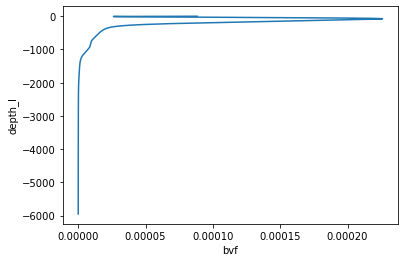

In [14]:
ds_re = xr.open_zarr(out_file)
bvf_moy = ds_re.bvf.mean(dim=("x_c","y_c")).persist()
bvf_moy.plot(y="depth_l")

In [21]:
sds_re = xr.open_zarr(out_file)
ds_re = xr.open_zarr(scratch/"global_mean_bvf.zarr")
#bvf_re = ds_re.bvf.isel(x_c=1999, y_)
bvf_sr = sds_re.bvf.isel(x_c=[-1], y_c=[-1])

In [24]:
sds_re, ds_re = xr.align(sds_re.isel(x_c=[-1], y_c=[-1]), ds_re)
ds_re

<xarray.Dataset>
Dimensions:    (x_c: 1, y_c: 1, z_l: 300)
Coordinates:
  * x_c        (x_c) int64 2000
  * y_c        (y_c) int64 1000
    depth_l    (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(1, 1), meta=np.ndarray>
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    bvf        (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 1, 1), meta=np.ndarray>
Attributes:
    grid_file:  /scratch/cnt0024/ige2071/nlahaye/eNATL60_mean_grid_z.zarr
    mean_salt:  /work/CT1/ige2071/SHARED/mean/global_mean_gridS.zarr
    mean_temp:  /work/CT1/ige2071/SHARED/mean/global_mean_gridT.zarr

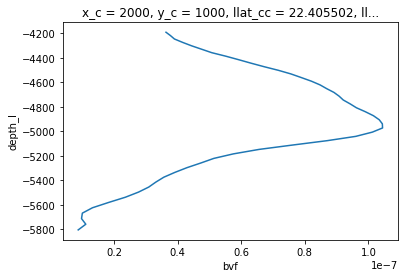

In [27]:
sds_re.bvf.isel(z_l=slice(-52,None)).plot(y="depth_l")

In [13]:
%%time
bvf2(sds).compute()

CPU times: user 23.1 s, sys: 33.1 s, total: 56.2 s
Wall time: 1min 42s


<xarray.DataArray 'bvf' (z_l: 300, y_c: 1000, x_c: 2000)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
          7.87976140e-05,  7.87034078e-05,  7.86151291e-05],
        [            nan,             nan,  3.51709359e-05, ...,
          7.89116195e-05,  7.88216520e-05,  7.87694829e-05],
        [            nan,             nan,             nan, ...,
          7.89817732e-05,  7.89567317e-05,  7.89504024e-05]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [            nan,             nan,             nan, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [            nan,             nan, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [            nan,             nan,             nan, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [            nan,             nan, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [            nan,             nan,             nan, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]]])
Coordinates:
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c         (y_c) int64 1 2 3 4 5 6 7 8 ... 993 994 995 996 997 998 999 1000
  * x_c         (x_c) int64 1 2 3 4 5 6 7 ... 1994 1995 1996 1997 1998 1999 2000
    depth_l     (z_l) float64 -0.0 -1.0 -2.157 ... -5.901e+03 -5.95e+03 -6e+03
    e3w         (z_l, y_c, x_c) float64 nan nan nan nan ... 50.46 50.46 50.46
    depth_l_3d  (z_l, y_c, x_c) float32 nan nan nan ... -0.007238 -0.007285
    tmaskutil   (y_c, x_c) int8 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
    llon_cc     (y_c, x_c) float32 -97.88 -97.87 -97.85 ... -64.6 -64.58 -64.57
    llat_cc     (y_c, x_c) float32 6.337 6.337 6.337 6.337 ... 22.41 22.41 22.41

## Old stuff


In [5]:
%%time
#chk_z = 20
ds_tot = load_xorca_dataset(data_files=[], aux_files=grid_files,
                              decode_cf=True, model_config="nest"#, target_ds_chunks={"z_c":chk_z, "z_l":chk_z}
                             ).reset_coords(drop=True)
print("dataset is {:.1f} GB".format(ds_tot.nbytes/1e9))

dataset is 525.4 GB
CPU times: user 9.67 s, sys: 1.03 s, total: 10.7 s
Wall time: 10.7 s


CPU times: user 20.9 s, sys: 6.07 s, total: 27 s
Wall time: 26.5 s


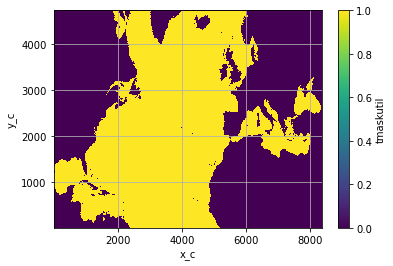

In [6]:
ds_tot

In [13]:
### First load zarr of corected vertical grid
ds_grz = xr.open_zarr(grid_path/zgrid_name)
ds_tot = ds_tot.merge(ds_grz.set_coords("hbot")).drop_vars("sossheig").unify_chunk()

CPU times: user 53min 40s, sys: 4min 56s, total: 58min 37s
Wall time: 58min 25s


In [7]:
i_rng = slice(4014-1, 4134)
j_rng = slice(1438-1, 1576)

sds = ds_tot.isel(x_c=i_rng, x_r=i_rng, y_c=j_rng, y_r=j_rng)
sds

<xarray.Dataset>
Dimensions:     (x_c: 121, x_r: 121, y_c: 139, y_r: 139, z_c: 300, z_l: 300)
Coordinates: (12/39)
  * x_c         (x_c) int64 4014 4015 4016 4017 4018 ... 4131 4132 4133 4134
  * y_c         (y_c) int64 1438 1439 1440 1441 1442 ... 1573 1574 1575 1576
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_r         (y_r) float64 1.438e+03 1.44e+03 ... 1.576e+03 1.576e+03
  * x_r         (x_r) float64 4.014e+03 4.016e+03 ... 4.134e+03 4.134e+03
    ...          ...
    fmask       (z_c, y_r, x_r) int8 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    umaskutil   (y_c, x_r) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    vmaskutil   (y_r, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    fmaskutil   (y_r, x_r) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot        (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
Data variables:
    sossheig    (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    votemper    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    vosaline    (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>

In [14]:
bvf = get_bvf(sds.where(sds.tmask))
bvf

<xarray.DataArray (z_l: 300, y_c: 139, x_c: 121, z_c: 300)>
dask.array<truediv, shape=(300, 139, 121, 300), dtype=float64, chunksize=(299, 139, 121, 300), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * z_l         (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c         (y_c) int64 1438 1439 1440 1441 1442 ... 1573 1574 1575 1576
  * x_c         (x_c) int64 4014 4015 4016 4017 4018 ... 4131 4132 4133 4134
    depth_l     (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
  * z_c         (z_c) int64 1 2 3 4 5 6 7 8 ... 293 294 295 296 297 298 299 300
    depth_c     (z_c) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    ...          ...
    e2t         (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>
    e3t         (z_c, y_c, x_c) float64 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    e3w         (z_l, y_c, x_c, z_c) float64 dask.array<chunksize=(300, 139, 121, 300), meta=np.ndarray>
    tmask       (z_c, y_c, x_c) int8 dask.array<chunksize=(300, 139, 121), meta=np.ndarray>
    tmaskutil   (y_c, x_c) int8 dask.array<chunksize=(139, 121), meta=np.ndarray>
    hbot        (y_c, x_c) float64 dask.array<chunksize=(139, 121), meta=np.ndarray>

In [15]:
%%time
bvf.compute()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-4f894727f809dc6298528c32540749c4', 0, 0)": ['tcp://127.0.0.1:44045'], "('getitem-a5d6a77a05891b093bf1ef3c7435f696', 0, 0)": ['tcp://127.0.0.1:44045'], "('truediv-6cf40393a4c78236e732fd4b58be7701', 0, 0, 0, 0)": ['tcp://127.0.0.1:44045'], "('truediv-6cf40393a4c78236e732fd4b58be7701', 1, 0, 0, 0)": ['tcp://127.0.0.1:44045'], "('mul-4df54b8136e8432cbd1a5a5767bd2950', 0, 0, 0, 0)": ['tcp://127.0.0.1:44045']} state: ['waiting', 'waiting', 'waiting', 'waiting', 'waiting'] workers: ['tcp://127.0.0.1:44045']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:44045'], ('getitem-4f894727f809dc6298528c32540749c4', 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promi

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
